In [1]:
import pandas as pd
import deepmatcher as dm

In [ ]:
train_df = pd.read_csv('../../Structured/Walmart-Amazon/merged_train.csv')
train_pos = train_df[train_df.label==1].copy()
train_neg = train_df[train_df.label==0].copy()

In [17]:
validation_df = pd.read_csv('../../Structured/Walmart-Amazon/merged_valid.csv')
valid_pos = validation_df[validation_df.label==1].copy()
valid_neg = validation_df[validation_df.label==0].copy()

In [2]:
import random
import string
def randomStringDigits(stringLength=6):
    """Generate a random string of letters and digits """
    lettersAndDigits = string.ascii_letters + string.digits
    return ''.join(random.choice(lettersAndDigits) for i in range(stringLength))

In [6]:
def generateRandomCodes(codes_len,label):
    l1 = []
    l2 = []
    for i in range(codes_len):
        if label == 1 :
            c1 = randomStringDigits(random.randint(5,20))
            l1.append(c1)
            l2.append(c1)
        else:
            c1 = randomStringDigits(random.randint(5,20))
            c2 = randomStringDigits(random.randint(5,20))
            l1.append(c1)
            l2.append(c2)
    return l1,l2

In [7]:
l_neg,r_neg = generateRandomCodes(train_neg.shape[0],0)
l_pos,r_pos = generateRandomCodes(train_pos.shape[0],1)

In [8]:
train_neg['ltable_modelno'] = l_neg
train_neg['rtable_modelno'] = r_neg

In [9]:
train_pos['ltable_modelno'] = l_pos
train_pos['rtable_modelno'] = r_pos

In [19]:
l_neg,r_neg = generateRandomCodes(valid_neg.shape[0],0)
l_pos,r_pos = generateRandomCodes(valid_pos.shape[0],1)
valid_neg['ltable_modelno'] = l_neg
valid_neg['rtable_modelno'] = r_neg
valid_pos['ltable_modelno'] = l_pos
valid_pos['rtable_modelno'] = r_pos

In [10]:
train_pos.head()

,label,ltable_title,ltable_category,ltable_brand,ltable_modelno,ltable_price,rtable_title,rtable_category,rtable_brand,rtable_modelno,rtable_price,id
8,1,elite screens cinegray prime vision series fix...,electronics - general,elite screens,0wgCibD,1069.00,cinegray prime vision series fixed frame scree...,projection screens,elite,0wgCibD,1069.00,4699
35,1,michigan wolverines iphone 4 case silicone cover,electronics - general,tribeca,6vZAZj7ebYZz6iP,24.99,michigan wolverines iphone 4 case silicone cover,computers accessories,tribeca,6vZAZj7ebYZz6iP,17.99,1353
49,1,innovera d2130b black compatible high-yield to...,printers,innovera,Rt6hmGnmbiEsSlOxl,58.90,new-innovera d2130b - d2130b compatible high-y...,computer accessories,innovera,Rt6hmGnmbiEsSlOxl,78.00,1564
366,1,da-lite da-glas standard rear projection scree...,electronics - general,da-lite,oJo1jLPT6TKui4kVF,4448.99,da-lite 27639 da-glas standard rear projection...,projection screens,da-lite,oJo1jLPT6TKui4kVF,NaN,5013
510,1,pc treasures wireless optical mouse 2.4 ghz pu...,mice,pc treasures,MDxf2GL3q18nzk,17.82,pc treasures mighty mini mouse - 2.4 ghz wireless,mice,pc treasures,MDxf2GL3q18nzk,14.69,4586


In [11]:
train_neg.head()

,label,ltable_title,ltable_category,ltable_brand,ltable_modelno,ltable_price,rtable_title,rtable_category,rtable_brand,rtable_modelno,rtable_price,id
0,0,elite screens cinewhite cinema235 series fixed...,electronics - general,elite screens,gfmll3qyYmlGR1,409.0,cinegray ezframe series fixed frame screen - 1...,projection screens,elite,0kKzSqhd5cTQyO30j,879.0,5583
1,0,elite screens cinewhite cinema235 series fixed...,electronics - general,elite screens,8J8Nfi1uU,409.0,powergain prime vision series fixed frame scre...,projection screens,elite,637kHrg1CLxM,1069.0,1572
2,0,elite screens cinegray prime vision series fix...,electronics - general,elite screens,fZ3yIE7LbpUky6Zu89,1069.0,powergain prime vision series fixed frame scre...,projection screens,elite,gLXUAtJwuwQu7,1069.0,110
3,0,elite screens cinewhite cinema235 series fixed...,electronics - general,elite screens,1bKCNXT9d5VGBbahPJKo,409.0,cinewhite prime vision series fixed frame scre...,projection screens,elite,W6hJNs,929.0,1938
4,0,elite screens cinegray prime vision series fix...,electronics - general,elite screens,lQZND7uMLeu,1069.0,cinewhite prime vision series fixed frame scre...,projection screens,elite,Pploe7Xb6uyF85j,929.0,5694


In [12]:
train_df_with_randomcodes = pd.concat([train_neg,train_pos])
train_df_with_randomcodes.to_csv('../../Structured/Walmart-Amazon/train_with_randomcodes.csv',index=False)

In [20]:
valid_randomcodes = pd.concat([valid_neg,valid_pos])
valid_randomcodes.to_csv('../../Structured/Walmart-Amazon/validation_with_randomcodes.csv',index=False)

## Train model with new dataset

In [22]:
train,validation,test = dm.data.process('../../Structured/Walmart-Amazon/',train='train_with_randomcodes.csv',
                       validation='validation_with_randomcodes.csv',test='merged_test.csv',left_prefix='ltable_',
                       right_prefix='rtable_',cache='random.pth')

In [3]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')

In [31]:
hybrid_model.run_train(train,validation,best_save_path='../../models/walmartamazon_hybrid_random.pth',epochs=20,
                       pos_neg_ratio=10,batch_size=32)
hybrid_model.run_eval(test)

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    4.6 | Load Time:    2.5 || F1:  50.33 | Prec:  43.85 | Rec:  59.07 || Ex/s: 289.69



50.33112582781457

In [4]:
hybrid_model.load_state('../../models/walmartamazon_hybrid_random.pth')

In [6]:
import sys
sys.path.append('../..')

In [7]:
from utilities_functions.intermediate_layer_extraction import return_layer_input

In [8]:
neg_classifier_inputs,neg_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_negatives',
                                                  batch_size=128,model=hybrid_model,
                                                   layer=hybrid_model.classifier,
                                                  device=-1)

In [10]:
pos_classifier_inputs,pos_ids = return_layer_input('../../Structured/Walmart-Amazon/','test_positives',
                                                  batch_size=128,model=hybrid_model,
                                                  layer=hybrid_model.classifier,
                                                  device=-1)

In [11]:
hybrid_model = hybrid_model.cuda()

In [16]:
from utilities_functions.ri_calculator import find_smallest_variation_to_change_v1
from tqdm import tqdm

In [17]:
attributes =['title','category','brand','modelno','price']

In [20]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in neg_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(hybrid_model.classifier,
                                                             classifier_length= 900,
                                                             attribute_length= 180,input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],
                                                          class_to_reach=1)
            current_sample_ris.append(variation)
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

100%|██████████| 128/128 [00:14<00:00,  8.63it/s]


In [22]:
import torch

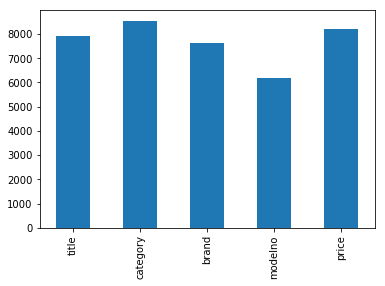

In [24]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)
ri_sums = negatives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [27]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri = []
for batch in pos_classifier_inputs:
    for sample_index in tqdm(range(len(batch))):
        current_sample_ris = []
        for j,attribute in enumerate(attributes):
            variation = find_smallest_variation_to_change_v1(hybrid_model.classifier,
                                                             classifier_length= 900,
                                                             attribute_length= 180,input_matrix=batch,
                                                             vector_index=sample_index,attributes=[j],class_to_reach=0)
            current_sample_ris.append(variation)
        positives_ri.append(current_sample_ris)
        current_sample+=1

100%|██████████| 65/65 [00:09<00:00,  7.02it/s]


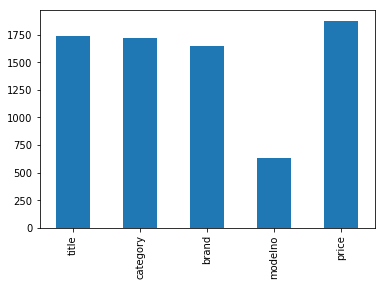

In [28]:
ri_norms_positives = []
for ri_list in positives_ri:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)
positives_variation_df.sum(numeric_only=True).plot.bar()